In [1]:
from skimage import data, img_as_float
from skimage.segmentation import chan_vese, active_contour
from skimage import measure
from skimage import measure
import numpy as np
from matplotlib.path import Path
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pickle
import train_cnn
import stacked_ae
import utils
%matplotlib inline

### Original (from Paper) model

#### Train

In [3]:
_, X_fullsize, _, contour_mask, y_pred, h, m = train_cnn.run(model='simple', history=True)

('Dataset shape :', (495, 64, 64, 1), (495, 1, 32, 32))


In [37]:
models_sae_loss = stacked_ae.run(X_fullsize, y_pred, contour_mask, history=True)

In [6]:
metrics_sae = utils.stats_results(models_sae_loss[1], models_sae_loss[2])

In [7]:
print('DM on Train Set %.2f' % metrics_sae[0].mean())

DM on Train Set 0.36


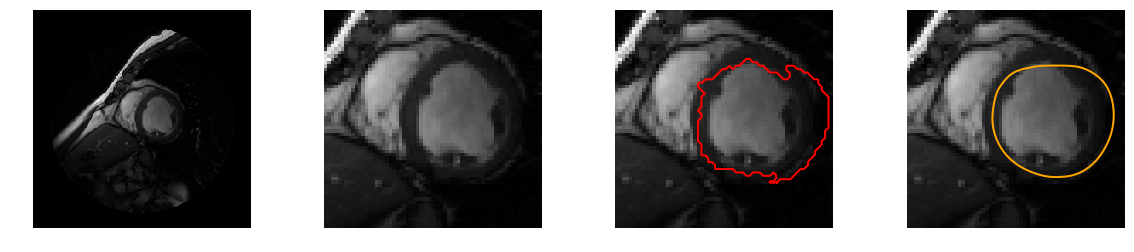

In [54]:
f, ax = plt.subplots(ncols=4, figsize=(20,4))
idx = 412
X_input = X_fullsize[idx].reshape((256,256))
X_roi = stacked_ae.open_data_AE(X_fullsize[idx:idx+1], y_pred[idx:idx+1], contour_mask[idx:idx+1])[0].reshape((64,64))

bin_pred = models_sae_loss[2][idx]
contours_pred = measure.find_contours(bin_pred, 0.8)
contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]

img = models_sae_loss[0][idx].reshape((64,64))
ac_contour = active_contour(img, contour_pred, alpha=0.01, beta=1)

ax[0].imshow(X_input, cmap='gray')
ax[1].imshow(X_roi, cmap='gray')
ax[2].imshow(img, cmap='gray')
ax[2].plot(contour_pred[:, 1], contour_pred[:, 0], linewidth=2, color='red',label='Prediction')
ax[3].imshow(img, cmap='gray')
ax[3].plot(ac_contour[:, 1], ac_contour[:, 0], linewidth=2, color='orange',label='Prediction')
for i in range(4):
    ax[i].axis('off')
plt.savefig('./Rapport/images/final_results.png')

In [ ]:
t = []
for idx in range(len(models_sae_loss[2])):
    bin_tru = models_sae_loss[1][idx].reshape((64,64))
    bin_pred = models_sae_loss[2][idx]
    contours_pred = measure.find_contours(bin_pred, 0.8)
    contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]
    img = models_sae_loss[0][idx].reshape((64,64))
    ac_contour = active_contour(img, contour_pred, alpha=0.001, beta=0.01) 
    # create mask contour with experts contours
    x, y = np.meshgrid(np.arange(64), np.arange(64)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 
    p = Path(ac_contour) # make a polygon
    grid = p.contains_points(points)
    mask_contour = grid.reshape(64,64)
    mask_contour=mask_contour*1
    t.append(utils.dice_metric(mask_contour.T, models_sae_loss[1][idx].reshape((64,64))))
print('DM on Train Set after Deformable Models %.2f' % np.mean(t))

#### Test

In [18]:
X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred = train_cnn.inference(m)

('Dataset shape :', (524, 64, 64, 1), (524, 1, 32, 32))


In [19]:
inference_sae_loss = stacked_ae.inference(X_fullsize_test, y_pred, contour_mask_test, models_sae_loss[3])

In [20]:
metrics_sae_loss_inf = utils.stats_results(inference_sae_loss[1], inference_sae_loss[2])

In [22]:
print('DM on Online Set %.2f' % metrics_sae_loss_inf[0].mean())

DM on Online Set 0.29


In [23]:
t = []
for idx in range(len(inference_sae_loss[2])):
    bin_tru = inference_sae_loss[1][idx].reshape((64,64))
    bin_pred = inference_sae_loss[2][idx]
    contours_pred = measure.find_contours(bin_pred, 0.8)
    contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]
    img = inference_sae_loss[0][idx].reshape((64,64))
    ac_contour = active_contour(img, contour_pred, alpha=0.001, beta=0.01) 
    # create mask contour with experts contours
    x, y = np.meshgrid(np.arange(64), np.arange(64)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 
    p = Path(ac_contour) # make a polygon
    grid = p.contains_points(points)
    mask_contour = grid.reshape(64,64)
    mask_contour=mask_contour*1
    t.append(utils.dice_metric(mask_contour.T, inference_sae_loss[1][idx].reshape((64,64))))
print('DM on Train Set after Deformable Models %.2f' % np.mean(t))

DM on Train Set after Deformable Models 0.29


Text(0.5,1,u'Ground Truth')

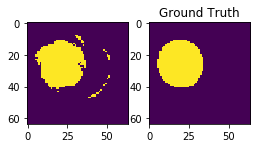

In [223]:
idx = 201
f, ax = plt.subplots(ncols=2, figsize=(4,8))
ax[0].imshow(inference_sae_loss[2][idx])
ax[1].imshow(inference_sae_loss[1][idx].reshape((64,64)))
ax[1].set_title('Ground Truth')

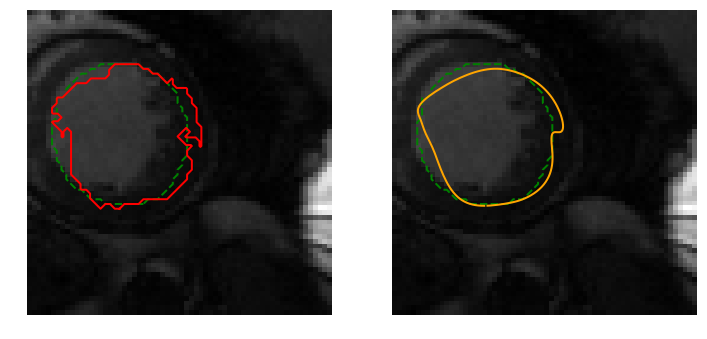

In [270]:
bin_tru = inference_sae_loss[1][idx].reshape((64,64))
bin_pred = inference_sae_loss[2][idx]
contour_truth = measure.find_contours(bin_tru, 0.8)[0]
contours_pred = measure.find_contours(bin_pred, 0.8)
contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]
img = inference_sae_loss[0][idx].reshape((64,64))
ac_contour = active_contour(img, contour_pred, alpha=0.005, beta=0.1)

f, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].imshow(img, cmap='gray')
ax[0].plot(contour_truth[:, 1], contour_truth[:, 0], linewidth=2, color='green',linestyle='dashed', label='Ground Truth')
ax[0].plot(contour_pred[:, 1], contour_pred[:, 0], linewidth=2, color='red',label='Prediction')
ax[1].imshow(img, cmap='gray')
ax[1].plot(contour_truth[:, 1], contour_truth[:, 0], linewidth=2, color='green',linestyle='dashed', label='Ground Truth')
ax[1].plot(ac_contour[:, 1], ac_contour[:, 0], linewidth=2, color='orange', label='Smooth Prediction')
ax[1].axis('off')
ax[0].axis('off')
plt.savefig('./Rapport/images/smoothness.png')

### All MSE

In [417]:
_, X_fullsize, _, contour_mask, y_pred, h, m = train_cnn.run(model='simple', history=True)
models_sae_loss = stacked_ae.run(X_fullsize, y_pred, contour_mask, history=True, loss1='MSE', loss2='MSE')

('Dataset shape :', (495, 64, 64, 1), (495, 1, 32, 32))


In [418]:
X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred = train_cnn.inference(m)
inference_sae_loss_mse = stacked_ae.inference(X_fullsize_test, y_pred, contour_mask_test, models_sae_loss[3])

('Dataset shape :', (524, 64, 64, 1), (524, 1, 32, 32))


In [419]:
metrics_sae_loss_inf = utils.stats_results(inference_sae_loss_mse[1], inference_sae_loss_mse[2])
metrics_sae_loss_2 = utils.stats_results(inference_sae_loss[1], inference_sae_loss[2])

In [420]:
print('DM on Online Set %.2f' % metrics_sae_loss_inf[0].mean())

DM on Online Set 0.41


Text(0.5,1,u'Truth')

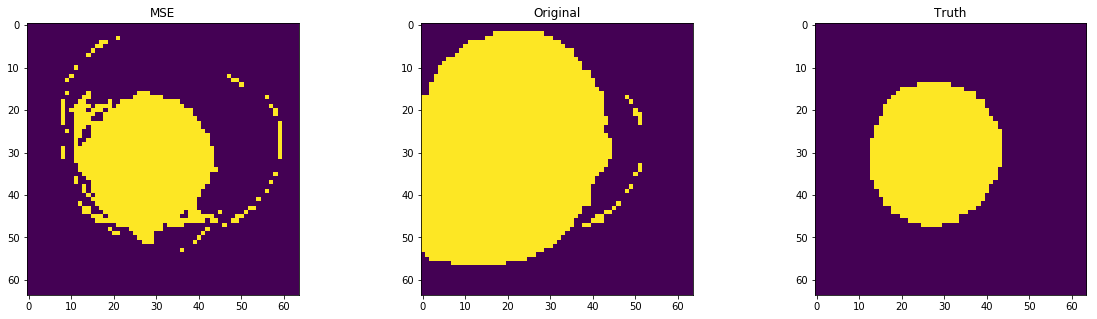

In [444]:
idx = 268
f, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].imshow(inference_sae_loss_mse[2][idx])
ax[0].set_title('MSE')
ax[1].imshow(inference_sae_loss[2][idx])
ax[1].set_title('Original')
ax[2].imshow(inference_sae_loss_mse[1][idx].reshape((64,64)))
ax[2].set_title('Truth')

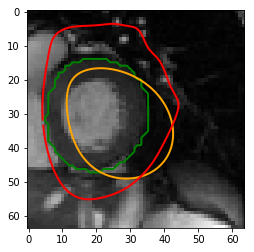

In [460]:
bin_tru = inference_sae_loss[1][idx].reshape((64,64))
bin_pred_orig = inference_sae_loss[2][idx]
bin_pred_mse = inference_sae_loss_mse[2][idx]
contour_truth = measure.find_contours(bin_tru, 0.8)[0]
contours_pred_orig = measure.find_contours(bin_pred_orig, 0.8)
contour_pred_orig = contours_pred_orig[np.argmax([k.shape[0] for k in contours_pred_orig])]
contours_pred_mse = measure.find_contours(bin_pred_mse, 0.8)
contour_pred_mse = contours_pred_mse[np.argmax([k.shape[0] for k in contours_pred_mse])]
img = inference_sae_loss[0][idx].reshape((64,64))
ac_contour_mse = active_contour(img, contour_pred_mse, alpha=0.01, beta=10.5)
ac_contour_orig = active_contour(img, contour_pred_orig, alpha=0.005, beta=0.1)

plt.imshow(img, cmap='gray')
plt.plot(contour_truth[:, 1], contour_truth[:, 0], linewidth=2, color='green', label='Ground Truth')
plt.plot(ac_contour_mse[:, 1], ac_contour_mse[:, 0], linewidth=2, color='orange', label='Prediction All MSE')
plt.plot(ac_contour_orig[:, 1], ac_contour_orig[:, 0], linewidth=2, color='red', label='Prediction Original')
plt.savefig('./Rapport/images/loss_smooth.png')

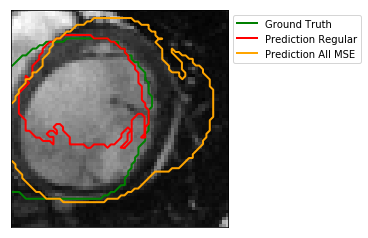

In [440]:
idx=234
from skimage import measure
# Find contours at a constant value of 0.8
contours_truth = measure.find_contours(inference_sae_loss[1][idx].reshape((64,64)), 0.9)
contours_simple = measure.find_contours(inference_sae_loss[2][idx], 0.9)
contours_mse = measure.find_contours(inference_sae_loss_mse[2][idx], 0.9)

fig, ax = plt.subplots()
ax.imshow(inference_sae_loss_mse[0][idx].reshape((64,64)), cmap='gray')

for n, contour in enumerate(contours_truth):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='green', label='Ground Truth')

for n, contour in enumerate(contours_simple[:1]):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red', label='Prediction Regular')

for n, contour in enumerate(contours_mse[:10]):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='orange', label='Prediction All MSE')
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('./Rapport/images/image_with_contour_truth_pred_SAE.png')

### Computing APD

In [190]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

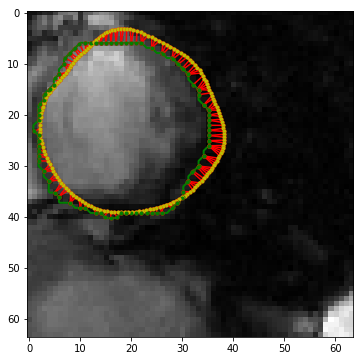

In [213]:
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.plot(contour_truth[:, 1], contour_truth[:, 0], linewidth=2, color='green', label='Ground Truth')
plt.plot(ac_contour[:, 1], ac_contour[:, 0], linewidth=2, color='orange', label='Smooth Prediction')
for i in range(171):
    j = closest_node(ac_contour[i,:], contour_truth)
    plt.plot([ac_contour[i,1], contour_truth[j,1]], [ac_contour[i,0], contour_truth[j,0]], marker = '.', color='red')
    plt.plot([ac_contour[i,1]], ac_contour[i,0],'y.', linewidth=0.1)
    plt.plot([contour_truth[j,1]], contour_truth[j,0],'g.')
plt.savefig('./Rapport/images/apd.png')